# [Getting Started with NLP](https://dphi.tech/bootcamps/getting-started-with-natural-language-processing?utm_source=header)
by [CSpanias](https://cspanias.github.io/aboutme/), 28/01 - 06/02/2022 <br>

Bootcamp organized by **[DPhi](https://dphi.tech/community/)**, lectures given by [**Dipanjan (DJ) Sarkar**](https://www.linkedin.com/in/dipanzan/) ([GitHub repo](https://github.com/dipanjanS/nlp_essentials)) <br>

This notebook constitutes my **personal submission** to the final assignment of the Bootcamp.

# CONTENT
1. [Problem Overview](#ProblemOverview)
2. [Import & Check Dataset](#Data)
    1. [Missing Values](#nans)
    1. [Duplicated Rows](#duplicates)
    1. [Balance](#balance)
3. [NLP Pipeline](#Pipeline)
    1. [Text Pre-Processing](#TextPre)
    1. [Train & Test Datasets](#SplitData)
    1. [Basic NLP Count-Based Features](#NLPCB)
    1. [Build a Classification Model](#MLModel)
        1. [K-Fold Cross-Validation](#KFold)

<a name="ProblemOverview"></a>
# 1. Problem Overview

> In this challenge, you will work on a dataset that contains **news headlines** - which are aimed to be **written in a sarcastic manner** by the news author. Our job here is to build our NLP models and **predict whether the headline is sarcastic or not**.

This problem represents a **binary classification problem** as the news headlines need to be **classified betweeen 2 categories**:
1. Sarcastic (1)
2. Not Sarcastic (0)

_More info about different Classification types [here](https://machinelearningmastery.com/types-of-classification-in-machine-learning/#:~:text=In%20machine%20learning%2C%20classification%20refers,one%20of%20the%20known%20characters.)._

<a name="Data"></a>
# 2. Import & Check Dataset

In [1]:
# import required libraries
import pandas as pd # import dataset, create and manipulate dataframes
import numpy as np # vectorize functions and perform calculations
import contractions # expand contractions
import re # regular expressions
import string # count-based features
import seaborn as sns # visualization
import matplotlib.pyplot as plt # visualization

from nltk.tokenize import word_tokenize # tokenize string or sentences
from nltk.corpus import stopwords # import english stopword list
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB # our ML algorithms
from sklearn.linear_model import LogisticRegression # our algorithm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # count-based language models
from sklearn.metrics import confusion_matrix, classification_report # model evaluation metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict # split & evaluate dataset
from sklearn.model_selection import KFold, GridSearchCV, cross_validate # split & evaluate dataset
from collections import Counter # count-based calculations
from textblob import TextBlob # sentiment analysis
from wordcloud import WordCloud # visualization

In [2]:
# load dataset as dataframe
df = pd.read_csv('https://github.com/CSpanias/nlp_resources/blob/main/dphi_nlp_bootcamp/final_assigment/Train_Dataset.csv?raw=true')

In [3]:
# check df's shape
print("The dataframe consists of {} rows and {} columns.".format(df.shape[0], df.shape[1]))
# check 1st 5 rows
df.head()

The dataframe consists of 44262 rows and 2 columns.


,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0


<a name="nans"></a>
We should first check our dataset for **missing values** as well as the **data type** of our variables.

We would expect that the **`headline`** and the **`is_sarcastic`** column to be of type **object** and **integer**, respectively, and ideally with **no missing values**.

In [4]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44262 entries, 0 to 44261
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      44262 non-null  object
 1   is_sarcastic  44262 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 691.7+ KB


<a name="duplicates"></a>
We can also check if we have any **duplicate rows** in our dataset.

In [5]:
# check for duplicates
print("Number of duplicated rows: {}".format(df.duplicated().sum()))

Number of duplicated rows: 17204


We have a **huge amount of duplicated rows**, so we will drop them.

In [6]:
# drop duplicated rows
df.drop_duplicates(keep='first', inplace=True)

# check duplicates
print("Number of duplicated rows: {}\n".format(df.duplicated().sum()))

# check shape
print("The dataframe consists of {} rows and {} columns.".format(df.shape[0], df.shape[1]))

Number of duplicated rows: 0

The dataframe consists of 27058 rows and 2 columns.


<a name="balance"></a>
We should also check if our dataset's distribution is **balanced or imbalanced** as this will **guide us on how we will treat our data** as well as the **algorithm selection** process.

In [7]:
# check label distribution
df['is_sarcastic'].value_counts()

0    14358
1    12700
Name: is_sarcastic, dtype: int64

As we can see, **our dataset is well-balanced**.

We can **visualize the sarcastic and non-sarcastic headlines** in our datasets using a **wordcloud**.

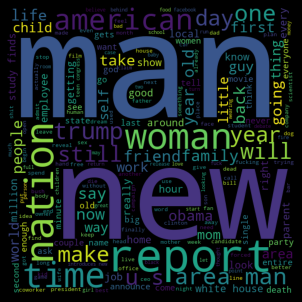

In [8]:
# generate a wordcloud for sarcastic headlines
sarcasm_wordcloud = WordCloud(width=512, height=512).generate(' '.join(df['headline'][df['is_sarcastic']==1]))
plt.figure(figsize=(6, 4), facecolor='k')
plt.imshow(sarcasm_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

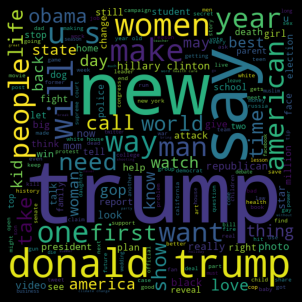

In [9]:
# generate a wordcloud for non-sarcastic headlines
nosarcasm_wordcloud = WordCloud(width=512, height=512).generate(' '.join(df['headline'][df['is_sarcastic']==0]))
plt.figure(figsize=(6, 4), facecolor='k')
plt.imshow(nosarcasm_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<a name="Pipeline"></a>
# 3. NLP Pipeline

The steps below will form our **NLP pipeline** for building our NLP models:
1. [Text Pre-Processing](#TextPre)
1. [Basic NLP Count-Based Features](#NLPCB)
1. [Sentiment Analysis](#sentana)
1. [Bag of Words](#BoW)
1. [Build a Classification Model](#MLModel)
    1. [Train & Test Datasets](#SplitData)

<a name="TextPre"></a>
## 3.1 Text Pre-Processing

Normally, our $1^{st}$ step would be to perform some **basic text pre-processing** like:
* remove stopwords
* remove punctuation
* lower case characters
* stip whitespace
* expand contractions

In this case **stopwords**, **punctuation** as well as **character casing** could provide information regarding the **tone of the headline**, thus we will keep them as it is.

In [10]:
def normalize_document(doc):
    """Normalize the document by performing basic text pre-processing tasks."""

    # remove trailing whitespace
    nowhite = doc.strip()
    # expand contractions
    expanded = contractions.fix(nowhite)
    # tokenize document
    tokens = word_tokenize(expanded)
    # re-create document from tokens
    doc = ' '.join(tokens)
    
    return doc

# vectorize function for faster computations
normalize_corpus = np.vectorize(normalize_document)

# normalize 'description colum'
norm_corpus = normalize_corpus(list(df['headline']))

In [11]:
# check shape
print("The 'headline' column has {} rows.\n".format(df.headline.shape[0]))

# check first 5 rows
print("The first 5 headlines are:\n\n{}".format(df.headline.head()))

The 'headline' column has 27058 rows.

The first 5 headlines are:

0    supreme court votes 7-2 to legalize all worldl...
1    hungover man horrified to learn he made dozens...
2    emily's list founder: women are the 'problem s...
3        send your kids back to school with confidence
4            watch: experts talk pesticides and health
Name: headline, dtype: object


<a name="NLPCB"></a>
## 3.2 Basic NLP Count-based Features

A number of basic text based features can also be created which sometimes are helpful for **improving text classification models**. 

Some examples are:

- __Word Count:__ total number of words in the documents
- __Character Count:__ total number of characters in the documents
- __Average Word Density:__ average length of the words used in the documents
- __Puncutation Count:__ total number of punctuation marks in the documents
- __Upper Case Count:__ total number of upper count words in the documents
- __Title Word Count:__ total number of proper case (title) words in the documents

**Note**: _The aforementioned information comes from [this](https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/) article._

In [12]:
# check df
df

,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0
...,...,...
44243,gated community under siege by savages,1
44245,watching the world destroy itself,0
44249,fucker riding man's ass whole way out to cleve...,1
44250,pushy hermit crab girlfriend wants to move in,1


In [13]:
# calculate the total number of characters
df['char_count'] = df['headline'].apply(len)

# calculate total number of words
df['word_count'] = df['headline'].apply(lambda x: len(x.split()))

# calculate word density
df['word_density'] = df['char_count'] / (df['word_count']+1)

# calculate number of punctuation
df['punctuation_count'] = df['headline'].apply(lambda x: len("".join(punc for punc in x if punc in string.punctuation))) 

# calculate number to title-cased words
df['title_word_count'] = df['headline'].apply(lambda x: len([word for word in x.split() if word.istitle()]))

# calculate number of upper-cased words
df['upper_case_word_count'] = df['headline'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [14]:
# check df
df.head()

,headline,is_sarcastic,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count
0,supreme court votes 7-2 to legalize all worldl...,1,53,9,5.300000,1,0,0
1,hungover man horrified to learn he made dozens...,1,66,12,5.076923,0,0,0
2,emily's list founder: women are the 'problem s...,0,65,10,5.909091,4,0,0
3,send your kids back to school with confidence,0,45,8,5.000000,0,0,0
4,watch: experts talk pesticides and health,0,41,6,5.857143,1,0,0


It seems that **all characters** in the headline column **are already lower-cased**, thus we will discard the `title_word_count` and `upper_case_word_count` columns.

In [15]:
# remove columns
df.drop(columns=['title_word_count', 'upper_case_word_count'], inplace=True, axis=0)

# check df
df.head()

,headline,is_sarcastic,char_count,word_count,word_density,punctuation_count
0,supreme court votes 7-2 to legalize all worldl...,1,53,9,5.300000,1
1,hungover man horrified to learn he made dozens...,1,66,12,5.076923,0
2,emily's list founder: women are the 'problem s...,0,65,10,5.909091,4
3,send your kids back to school with confidence,0,45,8,5.000000,0
4,watch: experts talk pesticides and health,0,41,6,5.857143,1


<a name="sentana"></a>
## 3.3 Sentiment Analysis 

We want to **detect sarcasm** which is a very difficult task as it is highly **subjective**, **opinionated** and people often **express strong emotions** and **feelings** through it. 

This makes it a classic case where the text documents here are a good candidate for **extracting sentiment as a feature**.

The general expectation is that a **sarcastic headline** (label 1) should have a **negative sentiment** and a **non-sarcastic headline** (label 0) should have a **positive sentiment**.

**`TextBlob`** is an excellent open-source library for performing **sentiment analysis** based on a **sentiment lexicon** which leverages to give both **polarity and subjectivity scores**. 

- The **polarity score** is a float within the range [-1.0, 1.0]. 
- The **subjectivity** is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. 

This is **unsupervised**, **lexicon-based sentiment analysis** where **we don't have any pre-labeled data** saying which review migth have a positive or negative sentiment. 

**Note**: _The above information come from [this](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72) article._

In [16]:
# create a column & calculate polarity score
df['Polarity'] = df['headline'].apply(lambda row: TextBlob(row).sentiment[0])

# create a column & calculate subjectivity score
df['Subjectivity'] = df['headline'].apply(lambda row: TextBlob(row).sentiment[1])

In [17]:
# check df
df

,headline,is_sarcastic,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity
0,supreme court votes 7-2 to legalize all worldl...,1,53,9,5.300000,1,0.000000,0.000000
1,hungover man horrified to learn he made dozens...,1,66,12,5.076923,0,0.000000,0.066667
2,emily's list founder: women are the 'problem s...,0,65,10,5.909091,4,0.000000,0.000000
3,send your kids back to school with confidence,0,45,8,5.000000,0,0.000000,0.000000
4,watch: experts talk pesticides and health,0,41,6,5.857143,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...
44243,gated community under siege by savages,1,38,6,5.428571,0,0.000000,0.000000
44245,watching the world destroy itself,0,33,5,5.500000,0,-0.200000,0.000000
44249,fucker riding man's ass whole way out to cleve...,1,50,9,5.000000,1,0.200000,0.400000
44250,pushy hermit crab girlfriend wants to move in,1,45,8,5.000000,0,0.200000,0.100000


<a name="BoW"></a>
## 3.4 Bag of Words

This is perhaps the most simple vector space representational model for unstructured text. A vector space model is simply a mathematical model to **represent unstructured text as numeric vectors**, such that each dimension of the vector is a specific feature\attribute. 


**Note**: _The above information come from [this](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41) article._

In [18]:
# instatiate vectorizer
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))

# fit vectorizer to 'headline' and convert it to numpy array
df_bow = cv.fit_transform(df['headline']).toarray()
# create a pandas DataFrame
df_bow = pd.DataFrame(df_bow, columns=cv.get_feature_names())

# check first 5 rows
df_bow.head()

,00,000,00000000001,00003,000th,025,03,047,071,10,...,zoologist,zoologists,zoomed,zoroastrianism,zsa,zucker,zuckerberg,zz,éclairs,ünited
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we will **concatenate the 2 dataframes** so that we have all the information together.

In [20]:
# concatenate the 2 dataframes
df_comb = pd.concat([df, df_bow], axis=1)

# remove headline column
df_comb.drop(['headline'], axis=1)

# check first 5 rows
df_comb.head()

MemoryError: Unable to allocate 6.45 GiB for an array with shape (25738, 33612) and data type float64

In [ ]:
# assign feature & target variables and convert them to np array
X = df.drop(['is_sarcastic'], axis = 1).values
y = df['is_sarcastic'].values

# # check shape of X
print("X has {} rows and {} columns.\n".format(X.shape[0], X.shape[1]))
# # check shape of y
print("y has {} rows and 1 column.".format(y.shape[0]))

<a name="MLModel"></a>
# 3.5 Build a Classification Model

The first decision to make is **which algorithms to choose** for our **binary classification problem**.

One of the most popular and computationally cheap algorithms used for such problems is the **Naive Bayes** (NB) algorithm. 

Almost every [course](https://www.coursera.org/lecture/predictive-analytics/naive-bayes-spam-filtering-Tddfx) and [tutorial](https://towardsdatascience.com/email-spam-detection-1-2-b0e06a5c0472) uses the **Naive Bayes and Spam Filter** combination, and NB is also used heavily in solving [real-world problems](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8205562/) of this type!

There are **various implementations of NB**, but we will implement the ones that seem the most relevant according to [sklearn's documentations](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes):

> _"**MultinomialNB** implements the naive Bayes algorithm for multinomially distributed data, and is **one of the two classic naive Bayes variants used in text classification** (where the **data are typically represented as word vector counts**, although **tf-idf vectors** are also known to work well in practice)."_

> _"**BernoulliNB** implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be **multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable**."_

> _"**CategoricalNB** implements the categorical naive Bayes algorithm for categorically distributed data. It assumes that **each feature**, which is described by the index , **has its own categorical distribution**."_

We now must **concatenate the 2 seperate DataFrames into a single DataFrame**, and **remove `headline` column**.

In [ ]:
# concatenate the 2 dataframes
X_train_comb = pd.concat([X_train_metadata, X_traincv], axis=1)
X_test_comb = pd.concat([X_test_metadata, X_testcv], axis=1)

<a name="KFold"></a>
## 3.5.1 **K-Fold Cross-Validation**

**K-fold cross-validation** is a very useful technique to evaluate model performance. Instead of doing a single training-test split, we **split our dataset multiple times**. The reasons behind K-Fold are:
  1. A certain split selected randomly at the start (*random_state=10*) may not be optimal. 
  2. The test set generated from that split is never used to evaluate the model.

<img src="https://miro.medium.com/max/875/1*rgba1BIOUys7wQcXcL4U5A.png" alt="drawing" width="500"/>

In [ ]:
# select the model(s)
model_mnb = MultinomialNB()
#model_cat = CategoricalNB()
#model_gau = GaussianNB()

# choose how many train/test sets we want by "n_splits"
kfold = KFold(n_splits=10, shuffle=True, random_state=44)

mnb_scores = cross_val_score(model_mnb, X, y, cv=kfold)
# calculate the accuracy score of each of the 5 train/test sets
# mnb_scores = cross_val_score(model_mnb, X, y, cv=kfold)
# cat_scores = cross_val_score(model_cat, X, y, cv=kfold)
# gau_scores = cross_val_score(model_gau, X, y, cv=kfold)

# # print average cross-validation scores
# print('\nAverage stratified cross-validation score with Multinomial NB:',
#       round(mnb_scores.mean(), 4))
# print('Average stratified cross-validation score with Bernoulli NB:',
#       round(cat_scores.mean(), 4))
# print('Average stratified cross-validation score with Complement NB:',
#       round(gau_scores.mean(), 4))
# print('')
# # convert list of scores to dataframe
# mnb_splits = pd.DataFrame(mnb_scores, columns = ['Individual splits for MNB'])

In [ ]:
# y_pred = cross_val_predict(model_mnb, X, y, cv=kf)
# cm = confusion_matrix(y, y_pred)

# # visualize confusion matrix with seaborn heatmap
# cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
#                                            'Actual Negative:0'],
#                         index=['Predict Positive:1', 'Predict Negative:0'])
# fig, ax = plt.subplots(figsize=(7,7))  
# sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

<a name="SplitData"></a>
## 3.2 Train & Test Datasets

In [ ]:
# # assign feature & target variables
# X = df.drop(['is_sarcastic'], axis = 1)
# y = df['is_sarcastic']

# # split dataset into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # check shape of train & test sets
# print("The training set has {} rows and the testing set has {} rows.\n".format(X_train.shape[0], X_test.shape[0]))

# # check label's distribution for each set
# print("The label distribution is:\n\nTraining set: Label 1 = {} | Label 0 = {}.\n\nTest set: Label 1 = {} | Label 0 = {}\n".
#       format(Counter(y_train)[1], Counter(y_train)[0], Counter(y_test)[1], Counter(y_test)[0]))

# # check 1st 5 rows of each set
# print("The first 5 rows of X_train are:\n\n{}\n".format(X_train[:5]))
# print("The first 5 rows of X_test are:\n\n{}\n".format(X_test[:5]))
# print("The first 5 rows of y_train are:\n\n{}\n".format(y_train[:5]))
# print("The first 5 rows of y_test are:\n\n{}\n".format(y_test[:5]))

In [ ]:
# # instatiate vectorizer
# cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))

# # fit vectorizer to 'headline' and convert it to numpy array
# X_traincv = cv.fit_transform(X_train['headline']).toarray()
# # create a pandas DataFrame
# X_traincv = pd.DataFrame(X_traincv, columns=cv.get_feature_names())

# # use vectorizer to transform 'headline' and convert it to numpy array
# X_testcv = cv.transform(X_test['headline']).toarray()
# # create a pandas DataFrame
# X_testcv = pd.DataFrame(X_testcv, columns=cv.get_feature_names())

# # check first 5 rows
# X_traincv.head()

Extract the **required features** from each DataFrame.

In [ ]:
# remove the 2 columns
X_train_metadata = X_train.drop(['headline'], axis=1).reset_index(drop=True)
X_test_metadata = X_test.drop(['headline'], axis=1).reset_index(drop=True)

# check first 5 rows
X_train_metadata.head()

We now must **concatenate the 2 seperate DataFrames into a single DataFrame**, and **remove `headline` column**.

In [ ]:
# concatenate the 2 dataframes
X_train_comb = pd.concat([X_train_metadata, X_traincv], axis=1)
X_test_comb = pd.concat([X_test_metadata, X_testcv], axis=1)

In [ ]:
# instantiate logreg
lr = LogisticRegression(max_iter=200)

# train log reg
lr.fit(X_train_comb, y_train)

# predict on test data
predictions = lr.predict(X_test_comb)

# print classification report
print(classification_report(y_test, predictions))

# convert report to pandas DataFrame
pd.DataFrame(confusion_matrix(y_test, predictions))